In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from tqdm import tqdm
from cnn_models import LeNet
from PCLeNet import PCLeNet, PCLeNetv3, PCLeNetv3Deep
from PCLeNet_L1MoreFeatures import PCLeNetv2
from CustomDataset import PreloadedDataset
from train_loops import train, train_pc_classification, train_pc_error, train_pc_ec
from my_funcs import RandomGaussianNoise, Scale
import matplotlib.pyplot as plt

c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
VAL_RATIO = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(255.0),
    # transforms.RandomHorizontalFlip(p=0.5),
    RandomGaussianNoise(std=0.001),
    transforms.RandomAffine(degrees=20, translate=(0.15,0.15), scale=(0.90,1.10)),
])

dataset = datasets.MNIST(root="../../../datasets/", train=True, transform=transforms.ToTensor(), download=True)
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
INPUT_SHAPE = train_dataset[0][0].shape
NUM_CLASSES = 10

In [48]:
layer = nn.Conv2d(2, 8, (3,3))
layer.weight.shape

torch.Size([8, 2, 3, 3])

In [9]:
seed = 42
torch.manual_seed(seed)
#  Standard LeNet CNN
model_name = "LeNet"
LEARNING_RATE = 3e-3
lenet = LeNet(INPUT_SHAPE[0], NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.AdamW(lenet.parameters(), lr=LEARNING_RATE)
cnn_train_loss, cnn_train_acc, cnn_val_loss, cnn_val_acc, step = train(
    lenet,
    train_dataset,
    val_dataset,
    optimiser,
    criterion,
    model_name,
    150,
    batch_size=300,
    save_model=True,
    model_dir="MNIST/models/",
    log_dir="MNIST/logs/",
    device=device,
    step=7200000
)

In [4]:
seed = 42
torch.manual_seed(seed)
#  Standard LeNet CNN
model_name = f"PCLeNetv3_err"
LEARNING_RATE = 3e-4
lenet = PCLeNetv3(INPUT_SHAPE, NUM_CLASSES, relu_errs=True).to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.AdamW(lenet.parameters(), lr=LEARNING_RATE)
step = train_pc_ec(
    lenet,
    train_dataset,
    val_dataset,
    # optimiser,
    criterion,
    model_name,
    500,
    batch_size=300,
    log_dir="MNIST/logs/",
    model_dir="MNIST/models",
    save_model=True,
    device=device,
    best="acc"
)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [10, 84]], which is output 0 of AsStridedBackward0, is at version 3; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [5]:
# model_name = "PCLeNetv3_classification"
lenet = PCLeNetv3(INPUT_SHAPE, NUM_CLASSES, relu_errs=True).to(device)
lenet.load_state_dict(torch.load(f"MNIST/models/{model_name}.pth"))

<All keys matched successfully>

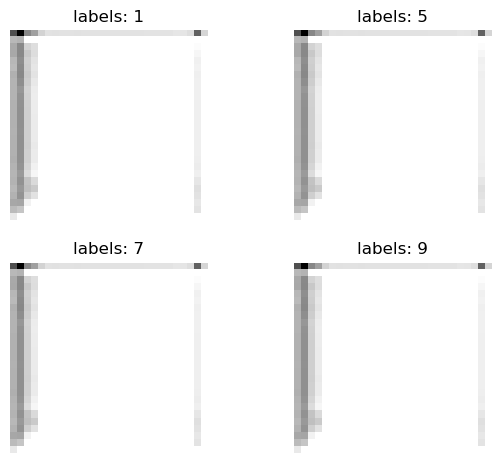

Error 0: 0.00014051437028683722
Error 1: 0.08776825666427612
Error 2: 0.012469873763620853
Error 3: 0.16494876146316528
Error 4: 0.32906079292297363


In [6]:
ys = F.one_hot(torch.tensor([1, 5, 7, 9]), 10).float().to(device)
out = lenet.predict(ys)
for i in range(4):
    ax = plt.subplot(2,2, i+1)
    plt.imshow(out[0][i].detach().squeeze(0).to("cpu"), cmap='gray')
    ax.set_title(f"labels: {ys[i].argmax().item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()
for i in range(len(out[1])):
    print(f"Error {i}: {out[1][i].square().mean()}")

In [4]:

torch.manual_seed(0)
#  Standard LeNet CNN
model_name = "PCLeNetv2_classification_DataAug"
LEARNING_RATE = 3e-4
lenet = PCLeNetv2(INPUT_SHAPE, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.AdamW(lenet.parameters(), lr=LEARNING_RATE)
step = train_pc_classification(
    lenet,
    train_dataset,
    val_dataset,
    optimiser,
    criterion,
    model_name,
    500,
    batch_size=300,
    log_dir="MNIST",
    save_model=False,
    device=device,
    plot_errs=True,
    step=step
)

NameError: name 'lenet' is not defined

In [12]:
torch.manual_seed(0)
model_name="PCLeNetAdamW_BS500_DataAug"
LEARNING_RATE = 3e-4
criterion = nn.CrossEntropyLoss()
pclenet = PCLeNet().to(device)
optimiser = optim.AdamW(pclenet.parameters())
optimiser.lr=LEARNING_RATE
pccnn_train_loss, pccnn_train_acc, pccnn_val_loss, pccnn_val_acc, step = train_pc(
    pclenet,
    train_dataset,
    val_dataset,
    optimiser,
    criterion,
    model_name,
    100,
    batch_size=500,
    log_dir="MNIST",
    device=device,
    save_model=True,
    step=0
)

In [13]:
torch.manual_seed(0)
model_name="PCLeNetAdamW_BS500_DataAug_LR=3e-3"
LEARNING_RATE = 3e-3
criterion = nn.CrossEntropyLoss()
pclenet = PCLeNet().to(device)
optimiser = optim.AdamW(pclenet.parameters())
optimiser.lr=LEARNING_RATE
pccnn_train_loss, pccnn_train_acc, pccnn_val_loss, pccnn_val_acc, step = train_pc(
    pclenet,
    train_dataset,
    val_dataset,
    optimiser,
    criterion,
    model_name,
    100,
    batch_size=500,
    log_dir="MNIST",
    device=device,
    save_model=True,
    step=0
)

In [14]:
torch.manual_seed(0)
model_name="PCLeNetAdamW_BS500_DataAug_LR=3e-3Sch2"
LEARNING_RATE = 3e-3
criterion = nn.CrossEntropyLoss()
pclenet = PCLeNet().to(device)
optimiser = optim.AdamW(pclenet.parameters())
optimiser.lr=LEARNING_RATE
pccnn_train_loss, pccnn_train_acc, pccnn_val_loss, pccnn_val_acc, step = train_pc(
    pclenet,
    train_dataset,
    val_dataset,
    optimiser,
    criterion,
    model_name,
    30,
    batch_size=500,
    log_dir="MNIST",
    device=device,
    save_model=True,
    step=0
)

optimiser.lr=3e-4
pccnn_train_loss, pccnn_train_acc, pccnn_val_loss, pccnn_val_acc, step = train_pc(
    pclenet,
    train_dataset,
    val_dataset,
    optimiser,
    criterion,
    model_name,
    70,
    batch_size=500,
    log_dir="MNIST",
    device=device,
    save_model=True,
    step=step
)

In [15]:

torch.manual_seed(0)
model_name="PCLeNetAdamW_BS500_DataAug_LR=3e-3Sch3"
LEARNING_RATE = 3e-3
criterion = nn.CrossEntropyLoss()
pclenet = PCLeNet().to(device)
optimiser = optim.AdamW(pclenet.parameters())
optimiser.lr=LEARNING_RATE
pccnn_train_loss, pccnn_train_acc, pccnn_val_loss, pccnn_val_acc, step = train_pc(
    pclenet,
    train_dataset,
    val_dataset,
    optimiser,
    criterion,
    model_name,
    30,
    batch_size=500,
    log_dir="MNIST",
    device=device,
    save_model=True,
    step=0
)

optimiser.lr=3e-4
pccnn_train_loss, pccnn_train_acc, pccnn_val_loss, pccnn_val_acc, step = train_pc(
    pclenet,
    train_dataset,
    val_dataset,
    optimiser,
    criterion,
    model_name,
    30,
    batch_size=500,
    log_dir="MNIST",
    device=device,
    save_model=True,
    step=step
)

optimiser.lr=3e-5
pccnn_train_loss, pccnn_train_acc, pccnn_val_loss, pccnn_val_acc, step = train_pc(
    pclenet,
    train_dataset,
    val_dataset,
    optimiser,
    criterion,
    model_name,
    40,
    batch_size=500,
    log_dir="MNIST",
    device=device,
    save_model=True,
    step=step
)